# DLProfile Example using mmaADSP Benchmark

## Set imports and neccessary environment variables

In [1]:
import pathlib
import os
import sys
import matplotlib.pyplot as plt
import warnings
import pprint
import pandas

In [2]:
VANIDL_DIR="{}".format(pathlib.Path(os.getcwd()).parent.absolute())
sys.path.insert(0, VANIDL_DIR)
warnings.filterwarnings('ignore')

In [3]:
os.environ["DARSHAN_DIR"] = "/soft/perftools/darshan/darshan-3.1.8"
os.environ["VANIDL_DIR"] = VANIDL_DIR

#### Formatting

In [4]:
pp = pprint.PrettyPrinter(indent=1)
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Create instrance of DL Profile and load the darshan file

In [5]:
from src.vanidl import VaniDL
profile = VaniDL()

In [6]:

DATAPATH_INCLUDES = []
status = profile.Load("/home/dhari/darshan-logs/apps/mmaadsp/run2_p1.darshan", data_paths_include=DATAPATH_INCLUDES)
if status:
    print("Darshan Trace loaded Successfully!")
else:
    print("Darshan Trace load Failed!")
    print(profile._error_str())

[============================================================] 100.0% 10187 of 10187 Parsing DXT File 
[============================================================] 100.0% 1090 of 1090 Parsing Darshan File 
Darshan Trace loaded Successfully!


## Use Profile object to analyze the darshan I/O trace.

### Verify if object works

The GetDXTAsDF() function enables users to perform analysis 

In [7]:
df = profile.GetDXTAsDF()
pp.pprint("Files used in the application")
pp.pprint(df['Filename'].unique().tolist())

'Files used in the application'
['/tmp/1awwgss4',
 '/home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/SNR_interval_0.h5',
 '/dev/urandom',
 '/gpfs/mira-home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/Time_results.txt']


In [8]:
df_normal = profile.GetTraceAsDF()
pp.pprint("Files used in the application")
pp.pprint(df_normal['Filename'].unique().tolist())

'Files used in the application'
['/gpfs/mira-home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/Time_results.txt',
 '/home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/SNR_interval_0.h5',
 '/dev/urandom',
 '/dev/null',
 '/tmp/1awwgss4']


### Collect the summary of the Application

In [10]:
pp.pprint("Job time : {} seconds".format(profile.GetJobTime()))

'Job time : 850.0 seconds'


In [11]:
pp.pprint("Time spent by application on I/O: {} seconds".format(profile.GetIOTime()/8))

'Time spent by application on I/O: 0.7134250000002273 seconds'


### I/O time spent on each file

In [12]:
for file in df['Filename'].unique():
    print("I/O time for file {}: {:0.2f} seconds".format(file,profile.GetIOTime(filepath=file)))

I/O time for file /tmp/1awwgss4: 0.00 seconds
I/O time for file /home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/SNR_interval_0.h5: 5.69 seconds
I/O time for file /dev/urandom: 0.01 seconds
I/O time for file /gpfs/mira-home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/Time_results.txt: 0.01 seconds


### I/O Time spent per rank

In [13]:
for rank in df['Rank'].unique():
    print("I/O time for rank {}: {:0.2f} seconds".format(rank,profile.GetIOTime(rank=rank)))

I/O time for rank 0: 5.71 seconds


In [14]:
"Total I/O performed by application: {:0.2f} GB".format(float(profile.GetIOSize())/1024.0/1024.0/1024.0)

'Total I/O performed by application: 0.61 GB'

### I/O performed on each file

In [15]:
for file in df['Filename'].unique():
    print("I/O performed on file {}: {:0.2f} MB".format(file,float(profile.GetIOSize(filepath=file))/1024.0/1024.0))

I/O performed on file /tmp/1awwgss4: 0.00 MB
I/O performed on file /home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/SNR_interval_0.h5: 625.38 MB
I/O performed on file /dev/urandom: 0.04 MB
I/O performed on file /gpfs/mira-home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/Time_results.txt: 0.00 MB


In [16]:
for rank in df['Rank'].unique():
    print("I/O performed by rank {}: {:0.2f} MB".format(rank, float(profile.GetIOSize(rank=rank))/1024.0/1024.0))

I/O performed by rank 0: 625.42 MB


In [17]:
print("Size of dataset (bytes)")
pp.pprint(profile.GetFileSizes())

Size of dataset (bytes)
{'SNR_interval_0': 655762048.0,
 'Time_results': 582.0,
 'null': 0.0,
 'urandom': 0.0}


In [18]:
file="/lus/theta-fs0/projects/MLPerfHPC/cosmoflow/dataset/cosmoUniverse_2019_02_4parE/dim128_cube_nT4/cosmoUniverse_2019_02_4parE-dim128_cube_nT4-rec1003.tfrecords"
!ls -l $file

-rw-r----- 1 memani MLPerfHPC 2147490944 Feb 12  2019 /lus/theta-fs0/projects/MLPerfHPC/cosmoflow/dataset/cosmoUniverse_2019_02_4parE/dim128_cube_nT4/cosmoUniverse_2019_02_4parE-dim128_cube_nT4-rec1003.tfrecords


### How application access data over time.

[============================================================] 100.0% 10030 of 10030 Creating Timeline 


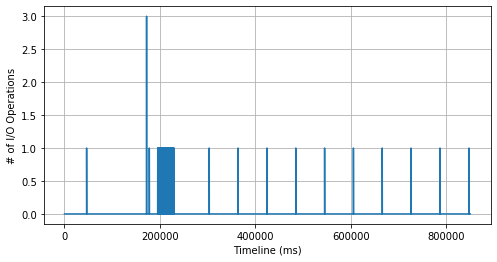

In [19]:
tl = profile.CreateIOTimeline(time_step=0.001)
plt.figure(figsize=(8,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("# of I/O Operations")
plt.grid()
plt.plot(tl['time_step'], tl['operation_count']);

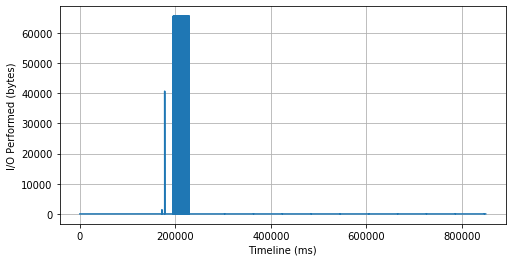

In [20]:
plt.figure(figsize=(8,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("I/O Performed (bytes)")
plt.grid()
plt.plot(tl['time_step'], tl['io_bytes']);

### How files are accessed over the duration of the Job.


[============================================================] 100.0% 1 of 1 Creating Timeline 


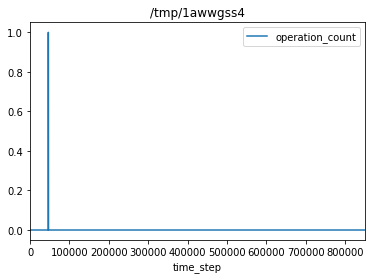

[============================================================] 100.0% 10016 of 10016 Creating Timeline 


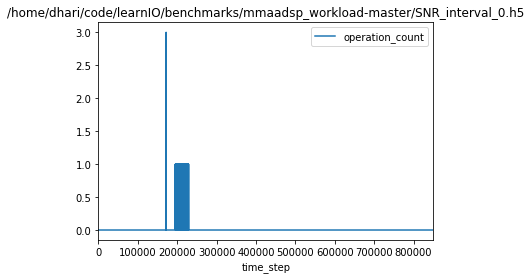

[============================================================] 100.0% 3 of 3 Creating Timeline 


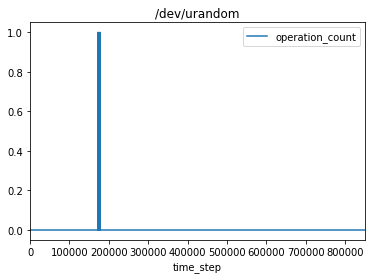

[============================================================] 100.0% 10 of 10 Creating Timeline 


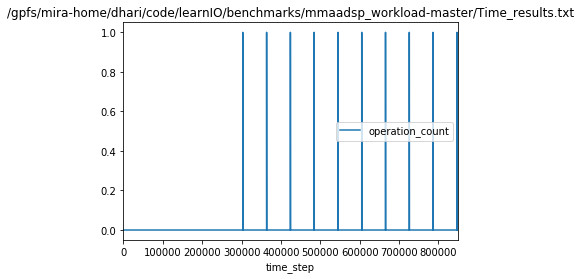

In [21]:
for file in df['Filename'].unique():
    tl = profile.CreateIOTimeline(filepath=file,time_step=0.001)
    tl.plot(x='time_step',y='operation_count', title=file)
    plt.show()

### Show how each file is accessed by each rank.

[============================================================] 100.0% 10030 of 10030 Creating Timeline 


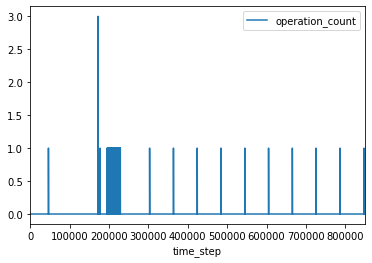

In [22]:
for rank in df['Rank'].unique():
    tl = profile.CreateIOTimeline(rank=rank, time_step = 0.001)
    tl.plot(x='time_step',y='operation_count', title=rank)
    plt.show()

### Data Transfer Size distribution within the application

Text(0.5, 0, 'Transfer Size (bytes)')

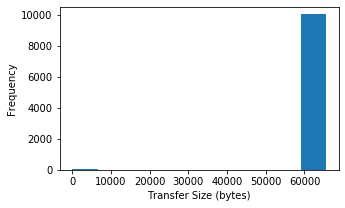

In [23]:
request_df = profile.GetIORequestDistribution()
df['Length'].plot(kind='hist', figsize=(5, 3));
plt.xlabel("Transfer Size (bytes)")

### Data Transfer Size distribution for each file.

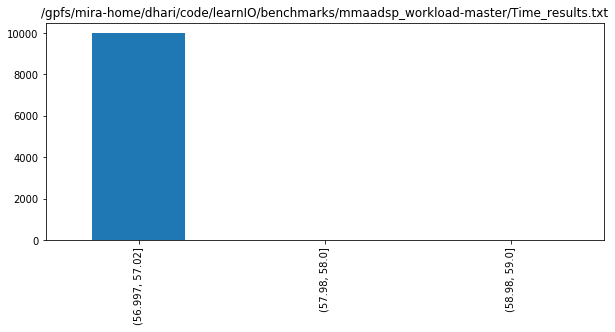

In [24]:
for file in df['Filename'].unique():
    tl = profile.GetIORequestDistribution(filepath=file)
    tl.plot(kind='bar', figsize=(10, 4), title=file)

### Data Transfer Sizes per Rank

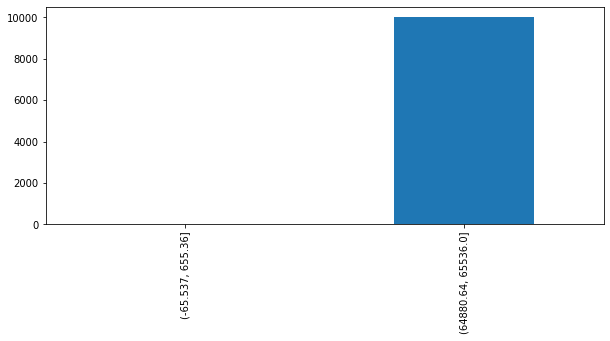

In [25]:
for rank in df['Rank'].unique():
    tl = profile.GetIORequestDistribution(rank=rank)
    tl.plot(kind='bar', figsize=(10, 4), title=rank)
    plt.show()

### File summary of each file accessed by the Application

In [28]:
pp = pprint.PrettyPrinter(indent=1)
for file in df['Filename'].unique():
    if os.path.exists(file):
        pp.pprint(profile.GetFileSummary(file))

{'ext': 'h5',
 'filename': 'SNR_interval_0',
 'io_size': 655763120,
 'io_time': 5.692400000001754,
 'path': '/home/dhari/code/learnIO/benchmarks/mmaadsp_workload-master/SNR_interval_0.h5',
 'size': 655762048,
 'special': {'keys': [{'name': 'train_data',
                       'obj': <HDF5 dataset "train_data": shape (10000, 8192), type "<f8">,
                       'shape': (10000, 8192),
                       'size': 81920000,
                       'type': 'dataset'},
                      {'name': 'train_label',
                       'obj': <HDF5 dataset "train_label": shape (10000, 5), type "<f8">,
                       'shape': (10000, 5),
                       'size': 50000,
                       'type': 'dataset'}],
             'name': 'SNR_interval_0',
             'type': 'group'}}
{'ext': '/dev/urandom',
 'filename': 'urandom',
 'io_size': 40714,
 'io_time': 0.00929999999999609,
 'path': '/dev/urandom',
 'size': 0,
 'special': {}}
{'ext': 'txt',
 'filename': 'Time_resu